Refs

 * [Hyperopt: A Python Library for Optimizing the Hyperparameters of Machine Learning Algorithms](https://conference.scipy.org/proceedings/scipy2013/pdfs/bergstra_hyperopt.pdf)
 * [Hyperopt-Sklearn](https://www.ml4aad.org/wp-content/uploads/2018/07/automl_book_draft_hyperopt-sklearn.pdf)

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

## Load Data and prep data 

In [2]:
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
DATA_LOCAL = "data/wdbc.data"
SEED = 42

names = ['id_number', 'diagnosis', 'radius_mean', 
         'texture_mean', 'perimeter_mean', 'area_mean', 
         'smoothness_mean', 'compactness_mean', 'concavity_mean',
         'concave_points_mean', 'symmetry_mean', 
         'fractal_dimension_mean', 'radius_se', 'texture_se', 
         'perimeter_se', 'area_se', 'smoothness_se', 
         'compactness_se', 'concavity_se', 'concave_points_se', 
         'symmetry_se', 'fractal_dimension_se', 
         'radius_worst', 'texture_worst', 'perimeter_worst',
         'area_worst', 'smoothness_worst', 
         'compactness_worst', 'concavity_worst', 
         'concave_points_worst', 'symmetry_worst', 
         'fractal_dimension_worst'] 

df = pd.read_csv(DATA_LOCAL,header=None, names=names)

In [3]:
X = df.iloc[:, 2:].values
y = df.diagnosis.values

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED)

In [6]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

## Hyperopt

### Simple (to the point of stupid) Example

In [7]:
from hyperopt import hp

Step 1: Define objective function

The objective function is function we wish to maxamise/minimise.

In [8]:
def obj(args):
    x, y = args
    return x**2 + y**2

Aside: plot function to show how smooth and easy it is

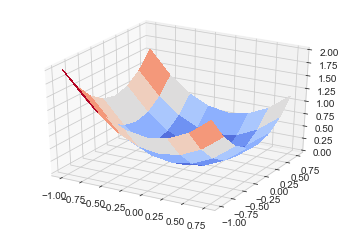

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')
xs = np.arange(-1, 1, 0.25)
ys = np.arange(-1, 1, 0.25)
xs, ys = np.meshgrid(xs, ys)
zs = (xs**2 + ys**2)
surf = ax.plot_surface(xs, ys, zs, cmap=cm.coolwarm,linewidth=0, antialiased=False)

plt.show()

Step 2: Define a configuration space
    
A configuration space is a region (domain) over which the search is performed. for each parameter specify its distribution.cs

In [10]:
space = [hp.normal('x', 0,1), hp.uniform('y',-2, 1)]

Step 3: Choose a search algorithm

In [11]:
from hyperopt import hp, fmin, rand, tpe, space_eval 
best = fmin(obj, space, algo=rand.suggest, max_evals=100)
print (best)

print ("rand", space_eval(space, best))
best = fmin(obj, space, algo=tpe.suggest, max_evals=100)
print (best)
print ("tpe", space_eval(space, best))

100%|██████████| 100/100 [00:00<00:00, 1543.19it/s, best loss: 0.04219949674910985]
{'x': -0.12504205662012438, 'y': 0.16298460303145035}
rand (-0.12504205662012438, 0.16298460303145035)
100%|██████████| 100/100 [00:00<00:00, 384.15it/s, best loss: 0.0005961443300483466]
{'x': 0.010437987834572723, 'y': -0.022072443000575592}
tpe (0.010437987834572723, -0.022072443000575592)


In [12]:
from hyperopt import Trials
trials = Trials()

best = fmin(obj, space, algo=tpe.suggest, max_evals=10, trials=trials)
print (best)
print ("tpe", space_eval(space, best))

100%|██████████| 10/10 [00:00<00:00, 831.81it/s, best loss: 0.1443624684028026]
{'x': 0.03134513945280643, 'y': 0.37865545108381404}
tpe (0.03134513945280643, 0.37865545108381404)


In [13]:
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': 0.1443624684028026, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'x': [0], 'y': [0]},
   'vals': {'x': [0.03134513945280643], 'y': [0.37865545108381404]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2019, 2, 26, 10, 47, 47, 246000),
  'refresh_time': datetime.datetime(2019, 2, 26, 10, 47, 47, 246000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': 3.23284404867748, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'x': [1], 'y': [1]},
   'vals': {'x': [-0.7204040778947302], 'y': [-1.6473803486839715]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2019, 2, 26, 10, 47, 47, 247000),
  'refresh_time': datetime.datetime(2019, 2, 26, 10, 47, 47, 247000)},
 {'state': 2,
  'tid': 2,
  's

## Example 2

In [14]:
from hyperopt import anneal, rand, tpe, mix
from hpsklearn import HyperoptEstimator, partial

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


Define an algorithm that searches randomly 5% of the time, uses Tree-structured Parzen Estimator (TPE) 75% of the time, and uses simulated annealing 20% of the time.

In [15]:
mix_algo = partial(mix.suggest, p_suggest=[
    (0.05, rand.suggest),
    (0.75, tpe.suggest),
    (0.20, anneal.suggest)])

In [16]:
from hpsklearn import svc_rbf
estimate = HyperoptEstimator(
    classifier=svc_rbf("my_svc"), 
    algo=mix_algo,
    max_evals=150,
    trial_timeout=60)
estimate.fit(X_train_scaled, y_train)

100%|██████████| 1/1 [00:00<00:00, 24.98it/s, best loss: 0.02197802197802201]


In [17]:
print(estimate.score(X_test_scaled, y_test))
print(estimate.best_model())

0.9824561403508771
{'learner': SVC(C=18.82666607535831, cache_size=512, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma=0.02339235968169092,
  kernel='rbf', max_iter=43120254.0, probability=False, random_state=0,
  shrinking=True, tol=0.00024399815162693506, verbose=False), 'preprocs': (Normalizer(copy=True, norm='l2'),), 'ex_preprocs': ()}
